## pip install

In [1]:
#!pip install seaborn
#!pip install torch
#!pip install pennylane --upgrade
#!pip install torchvision
#!pip install jax
#!pip install boto
#!pip install kaggle
#!pip install --upgrade "jax[cpu]"

## Imports

In [2]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix
import random

import torch
#from torchvision import datasets, transforms

#import jax
#import jax.numpy as jnp


#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## Data

In [4]:
df=pd.read_csv("creditcard.csv", )
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print('No Frauds: ', df['Class'].value_counts()[0])
print('Frauds: ', df['Class'].value_counts()[1])

No Frauds:  284315
Frauds:  492


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,over_average,under_average
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,31
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,31
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,30
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1,30
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,31
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,0,31
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,0,31
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,1,30
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0,1,30
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0,0,31


In [10]:
# time -> time from previous transaction
new_time=[0]
for t in range(1,len(df.Time)):
    new_time.append(df.Time[t]-df.Time[t-1])
df["Time"]=new_time

df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,over_average,under_average
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,31
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,31
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,30
3,0.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1,30
4,1.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,31
5,0.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,0,31
6,2.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,0,31
7,3.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,1,30
8,0.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0,1,30
9,2.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0,0,31


In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,over_average,under_average
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.606699,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,0.549168,30.450832
std,1.053380,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,1.060697,1.060697
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000,16.000000
25%,0.000000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,0.000000,30.000000
50%,0.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000,31.000000
75%,1.000000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,1.000000,31.000000
max,32.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,15.000000,31.000000


In [12]:
for col in df:
    if col not in ["Class" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,over_average,under_average
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.018959,4.815006e-16,1.536810e-17,-1.484918e-16,1.230945e-16,2.918942e-17,2.029538e-17,-4.659080e-18,5.678838e-18,-1.548567e-16,...,1.143876e-17,9.754629e-16,7.005460e-17,4.795375e-16,-1.157578e-17,-3.625678e-18,0.003439,0.001727,0.036611,0.982285
std,0.032918,7.978622e-01,7.486304e-02,1.616036e-01,8.390161e-02,3.966036e-02,1.817519e-02,1.025872e-02,5.969613e-02,7.044774e-02,...,2.771879e-02,1.321061e-01,6.932268e-02,1.370997e-01,1.276825e-02,9.751984e-03,0.009736,0.041527,0.070713,0.034216
min,0.000000,-2.297724e+01,-3.296610e+00,-5.150577e+00,-3.367736e-01,-3.268329e+00,-3.568885e-01,-3.612026e-01,-3.659517e+00,-8.614345e-01,...,-1.988943e+00,-6.187363e-01,-1.369144e+00,-7.404875e-01,-7.138282e-01,-4.558666e-01,0.000000,0.000000,0.000000,0.516129
25%,0.000000,-3.749082e-01,-2.713561e-02,-9.489574e-02,-5.028876e-02,-1.987253e-02,-1.048129e-02,-4.594728e-03,-1.042773e-02,-4.123743e-02,...,-7.184099e-03,-7.734373e-02,-4.217585e-02,-9.296326e-02,-2.240892e-03,-1.564645e-03,0.000218,0.000000,0.000000,0.967742
50%,0.000000,7.376503e-03,2.968826e-03,1.916816e-02,-1.176067e-03,-1.561300e-03,-3.740532e-03,3.325587e-04,1.117499e-03,-3.297772e-03,...,-4.968362e-04,8.937860e-03,2.206703e-03,-1.482342e-02,4.245659e-05,3.321879e-04,0.000856,0.000000,0.000000,1.000000
75%,0.031250,5.359182e-01,3.643729e-02,1.094793e-01,4.404896e-02,1.758325e-02,5.437327e-03,4.730396e-03,1.636140e-02,3.829043e-02,...,6.553594e-03,9.587128e-02,4.664026e-02,6.850398e-02,2.880063e-03,2.312704e-03,0.003004,0.000000,0.066667,1.000000
max,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000


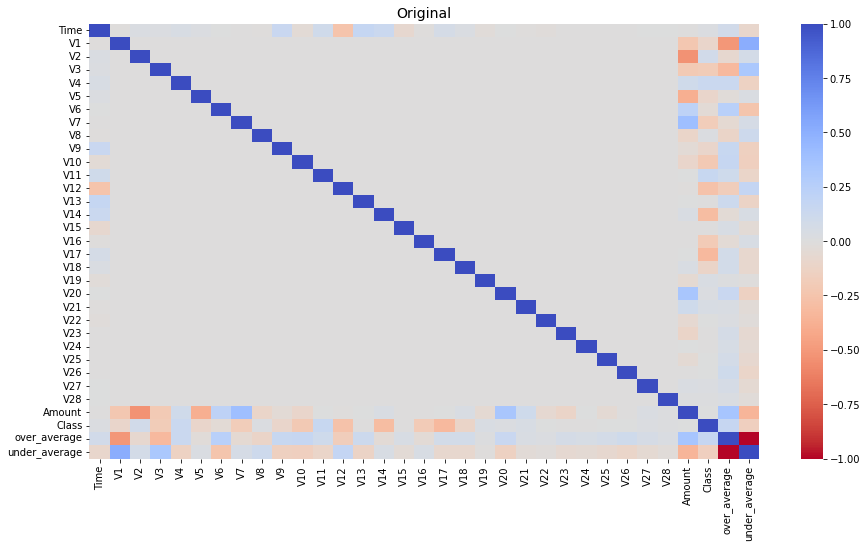

In [13]:
plot_correlation_matrix(df, "Original")

In [14]:
legal=df[df["Class"]==0]
legal.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,over_average,under_average
0,0.00000,-0.553909,-0.003300,0.270326,0.081667,-0.009721,0.006308,0.001987,0.004933,0.023327,...,-0.004904,0.014599,0.017094,-0.053766,0.004225,-0.000622,0.005824,0,0.000000,1.000000
1,0.00000,0.485495,0.012066,0.017744,0.026557,0.001725,-0.001124,-0.000653,0.004254,-0.016379,...,0.004496,-0.074129,0.022231,0.035792,-0.000284,0.000435,0.000105,0,0.000000,1.000000
2,0.03125,-0.553317,-0.060757,0.188990,0.022505,-0.014459,0.024563,0.006563,0.012379,-0.097124,...,0.040367,-0.150349,-0.043572,-0.039546,-0.001751,-0.001765,0.014739,0,0.066667,0.967742
3,0.00000,-0.393605,-0.008397,0.191099,-0.051157,-0.000296,0.017015,0.001970,0.018865,-0.088940,...,-0.008448,-0.256421,0.086092,-0.063096,0.001984,0.001816,0.004807,0,0.066667,0.967742
4,0.03125,-0.471799,0.039793,0.165063,0.023883,-0.011700,0.001309,0.004917,-0.013522,0.052436,...,-0.006102,0.030814,-0.027396,0.142804,0.006941,0.006356,0.002724,0,0.000000,1.000000


In [15]:
df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,over_average,under_average
266541,0.00000,-0.429925,0.055717,0.078548,-0.037398,0.013160,-0.004346,0.005155,0.018495,-0.061443,...,-0.014808,-0.105843,0.061905,0.114425,-0.009261,-0.001242,0.000077,0,0.000000,1.000000
119781,0.03125,-1.167595,0.106400,-0.432004,0.236046,-0.099512,-0.017475,-0.037107,0.060811,-0.148113,...,0.017954,0.061517,-0.067411,-0.105688,0.019463,0.023729,0.004847,1,0.333333,0.838710
60802,0.03125,-0.470641,0.039268,0.085021,0.059095,0.006166,-0.013870,0.007309,-0.005595,-0.042877,...,0.013799,0.074351,-0.068128,-0.224161,-0.009324,-0.005097,0.001840,0,0.000000,1.000000
44556,0.00000,-1.860070,0.152031,-0.487290,0.214284,-0.071638,-0.014870,-0.046036,0.022381,-0.155461,...,-0.013425,-0.018845,-0.068629,-0.083899,0.006200,0.004169,0.000039,1,0.333333,0.838710
123201,0.00000,0.465012,0.058537,-0.152720,0.121965,0.027034,-0.013073,0.003244,-0.004624,-0.002105,...,-0.006388,-0.066567,0.092760,-0.088858,0.003361,0.003695,0.000039,1,0.133333,0.935484


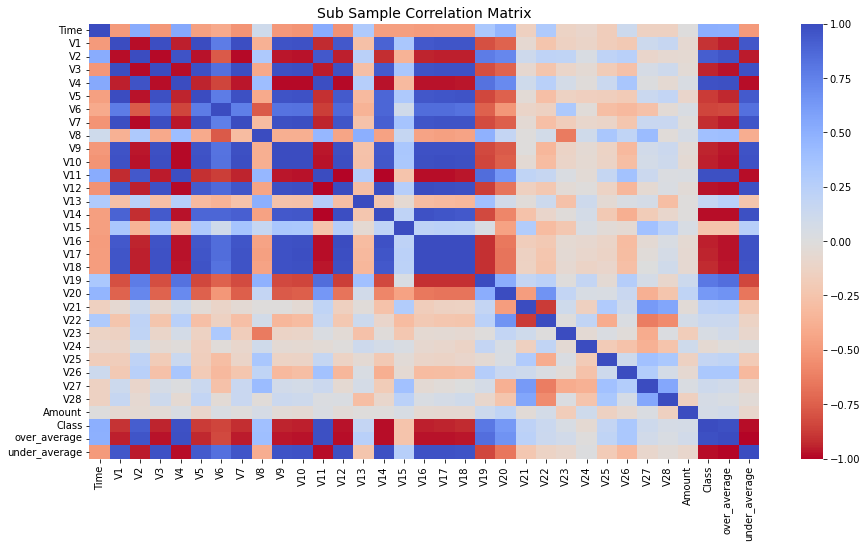

In [16]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

In [17]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['Class', :]
    class_correlations = class_correlations.drop(index = 'Class')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 16))

(['over_average', 'V14', 'V4', 'under_average', 'V11', 'V12', 'V2', 'V10', 'V19', 'V16', 'V20', 'V3', 'Time', 'V17', 'V21', 'V9'], [0.747305379946147, -0.7492582754283371, 0.7147528419904708, -0.7473053799461477, 0.6792717029920067, -0.6831521043920536, 0.491038237726285, -0.6262474617520667, 0.2365488050700914, -0.596920572282515, 0.17294005771213591, -0.5640065623182482, 0.15397511274961795, -0.5609275318638999, 0.12366799052104331, -0.5497433354225867])


In [18]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 16)

In [19]:
ilegal=df[df["Class"]!=0][feature_list]
ilegal.head()

,over_average,V14,V4,under_average,V11,V12,V2,V10,V19,V16,V20,V3,Time,V17,V21,V9
42958,0.466667,-0.930771,0.330720,0.774194,0.428354,-1.369655,0.287622,-0.618083,0.934973,-0.732035,-0.026007,-1.522151,0.00000,-2.241379,0.112418,-0.351787
6870,0.200000,-0.704653,0.166239,0.903226,0.525523,-1.104789,0.156074,-0.294793,0.065238,-0.210960,0.009156,-0.476230,0.21875,-0.680081,0.024554,-0.092299
144754,0.133333,-0.143307,0.156445,0.935484,-0.044081,0.127378,0.042851,-0.087172,0.163301,-0.018965,0.037415,0.065020,0.03125,0.245341,-0.092066,0.013479
106998,0.133333,-0.531157,0.238725,0.935484,0.133289,-0.359939,0.074204,-0.121919,-0.024342,-0.158116,0.009865,-0.161965,0.03125,-0.536178,0.012716,-0.106293
276071,0.133333,-0.173352,-0.044767,0.935484,0.111351,-0.042016,-0.034340,0.010499,0.075662,0.106401,0.000950,-0.127072,0.00000,0.129055,0.010596,-0.009037


In [20]:
legal=df[df["Class"]==0][feature_list]
legal.head()

,over_average,V14,V4,under_average,V11,V12,V2,V10,V19,V16,V20,V3,Time,V17,V21,V9
101914,0.000000,-0.003789,0.004410,1.000000,0.067902,0.105475,0.049872,-0.007554,0.058856,0.015487,0.002483,0.220077,0.00000,-0.015189,0.001019,0.015431
277403,0.000000,0.009775,-0.065239,1.000000,0.057985,0.004229,-0.034072,0.043250,0.159935,0.076359,0.000045,-0.139803,0.00000,-0.035347,0.013753,-0.045366
99556,0.000000,-0.047867,-0.005327,1.000000,-0.079383,-0.015414,-0.139588,-0.027264,-0.069213,-0.002919,-0.017994,0.218276,0.03125,0.017451,-0.011283,0.084376
88959,0.000000,-0.118706,-0.029275,1.000000,0.022988,-0.101679,-0.025310,0.004235,-0.011738,0.077587,0.005237,0.012355,0.06250,0.142223,0.004186,-0.045339
88295,0.066667,-0.067785,0.071039,0.967742,0.171038,0.065478,0.024389,-0.017952,-0.129634,0.021532,-0.004202,-0.018108,0.00000,0.086875,0.001280,-0.018040


In [21]:
input_data=legal.to_numpy()
input_data

array([[ 0.        , -0.00378914,  0.00440999, ..., -0.01518909,
         0.00101865,  0.01543064],
       [ 0.        ,  0.00977479, -0.06523887, ..., -0.03534714,
         0.01375256, -0.04536582],
       [ 0.        , -0.04786712, -0.00532713, ...,  0.01745117,
        -0.01128284,  0.08437634],
       ...,
       [ 0.13333333, -0.12912259,  0.00234203, ...,  0.2309158 ,
         0.00545383, -0.10702414],
       [ 0.06666667,  0.04707463, -0.04322029, ..., -0.03979681,
        -0.01078428,  0.0258656 ],
       [ 0.        ,  0.07192982,  0.02041037, ...,  0.00183639,
         0.00706743, -0.01108193]])

## Training node

In [22]:
shots = 2500
nr_trash=2
nr_latent=2
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6]


In [23]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, init_params)

    setAux(spec, reinit_state)

    #encoder

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [24]:
epochs = 200
learning_rate = 0.0003
batch_size = 2
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [25]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [26]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [27]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [28]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [ ]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_34528/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [ ]:
training_data[0]

In [ ]:
X_training = training_data
X_tes = test_data

In [ ]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

###  training

In [ ]:
np_ilegal = ilegal.to_numpy()
ilegal_data = [ torch.tensor([np_ilegal[i]]) for i in range(len(ilegal.to_numpy()))]

In [ ]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

ilegal_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
      
        ilegal_fidel = fidelity(encoder_params, ilegal_data )
        ilegal_fid.append(ilegal_fidel)
        print("benign fid:{}".format(ilegal_fidel))
        
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Params_Fraud_encoder_e2-SelectedFeautures_424/params_"+str(epoch)+".txt")
        f.write(str(experiment_parameters))
        f.close()
        

## Rezults

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(ilegal_fid),label="ilegal fid")

plt.legend()
plt.title(" 4-2-4->compression fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

In [ ]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title(" 4-2-4->compression loss e2",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

## Classifier

In [ ]:
legal_flist=[]
for b in legal_data:
    f=fidelity(encoder_params, [b])
    legal_flist.append(f.item())
    
print(min(legal_flist))
print(max(legal_flist))


In [ ]:
np_ilegal= ilegal.to_numpy()
ilegal_data = [ torch.tensor([np_ilegal[i]]) for i in range(len(ilegal.to_numpy()))]


ilegal_flist=[]
for b in ilegal_data:
    f=fidelity(encoder_params, [b])
    ilegal_flist.append(f.item())
    
print(min(ilegal_flist))
print(max(ilegal_flist))

In [ ]:
plt.hist(ilegal_flist, bins = 100 ,label="ilegal", color = "skyblue",alpha=0.4)
plt.hist(legal_flist, bins =100 ,label="legal",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()